In [127]:
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [128]:
path = '/kaggle/input/ecg-full-data/045_0-500000_corrected.csv'
data = pd.read_csv(path)
#Sample raw data
data.head(5)

,Time,Raw,Label
0,0.000000,-161.521893,0.0
1,0.000208,-178.571427,0.0
2,0.000416,-190.236900,0.0
3,0.000624,-188.442211,0.0
4,0.000832,-189.339555,0.0


In [129]:
data['Label'].value_counts()

Label
0.0    499356
1.0       644
Name: count, dtype: int64

In [130]:
time = data['Time']
voltage = data['Raw']
labels = data['Label']

In [131]:
def scaling(voltage):
    # Reshape the ECG data to a 2D array (assuming it's a single-channel signal)
    raw_ecg_data = np.array(voltage).reshape(-1, 1)

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler on the data and transform the data to normalized values
    normalized_ecg_data = scaler.fit_transform(raw_ecg_data)

    # Convert the normalized data back to a 1D array
    voltage_scaled = normalized_ecg_data.flatten()
    return voltage_scaled

In [132]:
def generate_windows(window_size, stride):
# Define parameters for segmentation
    window_size = window_size  # Size of each window
    stride = stride   # Stride between windows

    # Lists to store segmented windows and corresponding labels
    segmented_windows = []
    segment_labels = []

    # Segment the raw ECG data and extract features
    for i in range(0, len(voltage_scaled) - window_size + 1, stride):
        window = voltage_scaled[i : i + window_size]
        label = max(labels[i : i + window_size])  # Use the maximum label in the window

        # Extract features from the window (you can replace this with actual feature extraction methods)
        mean = np.mean(window)
        std = np.std(window)
        #peak_count = len(find_peaks(window, height=0)[0])  # Count peaks using scipy's find_peaks

        # Append the features to the segmented windows list
        segmented_windows.append([mean, std])

        # Append the label to the segment labels list
        segment_labels.append(label)

    # Convert lists to NumPy arrays for further processing
    segmented_windows = np.array(segmented_windows)
    segment_labels = np.array(segment_labels)

    # # Standardize the features
    # scaler = StandardScaler()
    # segmented_windows_standardized = scaler.fit_transform(segmented_windows)

    # Print a few examples to verify
#     for i in range(5):
#         print("Window:", segmented_windows[i])
#         print("Label:", segment_labels[i])
#         print()
    return segmented_windows,segment_labels

In [133]:
def generate_df(segmented_windows,segment_labels):
    # Define proper column names for your features
    column_names = ["Mean Voltage", "STD Voltage"]

    # Create a DataFrame from segmented windows and labels
    window_data = pd.DataFrame(data=segmented_windows, columns=column_names)

    # Add a column for the labels
    window_data["Label"] = segment_labels

    # Print the first few rows of the DataFrame to verify
    window_data.head(5)
    return window_data


In [134]:
def model_training(segmented_windows,segment_labels):
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(segmented_windows, segment_labels, test_size=0.2, random_state=42)
    from sklearn.svm import SVC
    svm_classifier = SVC(kernel='linear', C=1.0)  
    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train)
    return svm_classifier

# Testing the Model

In [135]:
test_path= '/kaggle/input/rodent-ecg/data.csv'
test_data = pd.read_csv(test_path)
t_voltage = test_data['Raw']
t_labels = test_data['Label']
t_time_t = test_data['Time']

In [136]:
def test_windowing(voltage_scaled,labels,time_t,window_size,stride):
    # Define parameters for segmentation
    window_size = window_size  # Size of each window
    stride = stride   # Stride between windows

    # Lists to store segmented windows and corresponding labels
    segmented_windows = []
    segment_labels = []

    # Segment the raw ECG data and extract features
    for i in range(0, len(voltage_scaled) - window_size + 1, stride):
        window = voltage_scaled[i : i + window_size]
        label = max(labels[i : i + window_size])  # Use the maximum label in the window
        time_tt = time_t[i : i + window_size]
        # Extract features from the window (you can replace this with actual feature extraction methods)
        mean = np.mean(window)
        std = np.std(window)
        mean_time = np.mean(time_tt)
        #peak_count = len(find_peaks(window, height=0)[0])  # Count peaks using scipy's find_peaks

        # Append the features to the segmented windows list
        segmented_windows.append([mean_time,mean, std])

        # Append the label to the segment labels list
        segment_labels.append(label)

    # Convert lists to NumPy arrays for further processing
    segmented_windows = np.array(segmented_windows)
    segment_labels = np.array(segment_labels)

    # # Standardize the features
    # scaler = StandardScaler()
    # segmented_windows_standardized = scaler.fit_transform(segmented_windows)

    # Print a few examples to verify
#     for i in range(5):
#         print("Window:", segmented_windows[i])
#         print("Label:", segment_labels[i])
#         print()
    return segmented_windows,segment_labels

In [137]:
def test_df(segmented_windows,segment_labels):
    # Define proper column names for your features
    column_names = ["Time","Mean Voltage", "STD Voltage"]

    # Create a DataFrame from segmented windows and labels
    window_data = pd.DataFrame(data=segmented_windows, columns=column_names)

    # Add a column for the labels
    window_data["Label"] = segment_labels

    # Print the first few rows of the DataFrame to verify
    window_data.head(5)
    X_test = window_data[['Mean Voltage', 'STD Voltage']].values
    y_test = window_data['Label'].values
    return window_data,X_test,y_test

# 100,100

In [138]:
voltage_scaled = scaling(voltage)
segmented_windows,segment_labels = generate_windows(100,100)
window_data = generate_df(segmented_windows,segment_labels)
svm_classifier = model_training(segmented_windows,segment_labels)
window_data['Label'].value_counts()

Label
0.0    4356
1.0     644
Name: count, dtype: int64

In [139]:
# Assuming 'window_data' is your DataFrame
label_counts = window_data['Label'].value_counts()

# Separate variables for each label count
label1_count = label_counts[0]
label2_count = label_counts[1]
label2_count

644

In [180]:
ll = []

In [181]:
for x in range(100,500,100):
    voltage_scaled = scaling(voltage)
    segmented_windows,segment_labels = generate_windows(x,x)
    window_data = generate_df(segmented_windows,segment_labels)
    svm_classifier = model_training(segmented_windows,segment_labels)
    label_counts = window_data['Label'].value_counts()
    label2_count = label_counts[1]
    ll.append(label2_count)

In [182]:
samp = []
for i in range(100,500,100):
    samp.append(i)

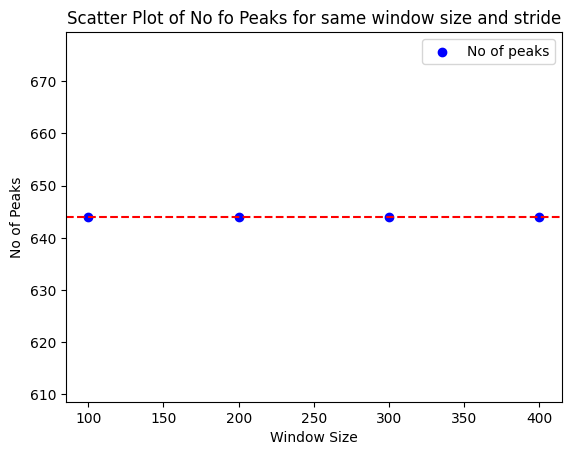

In [183]:
import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = ll

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='No of peaks')

# # Highlight the point with x=1 in red
# highlight_x = 100
# highlight_y = y[x.index(highlight_x)]
# plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Window Size')
plt.ylabel('No of Peaks')
plt.legend()

# Add a title
plt.title('Scatter Plot of No fo Peaks for same window size and stride')
# Add a vertical line at y = your_value_here
your_value_here = 644  # Adjust this value as needed
plt.axhline(y=your_value_here, color='red', linestyle='--', label=f'Y = Actual No. of peaks')


# # Set custom x-axis tick values with increased intervals
# custom_x_ticks = [50, 100, 200,400,450,500,1000]  # Adjust these values as needed
# plt.xticks(custom_x_ticks)

# Show the plot
plt.show()


In [184]:
ll = []
for x in range(100,500,100):
    voltage_scaled = scaling(voltage)
    segmented_windows,segment_labels = generate_windows(x,x-20)
    window_data = generate_df(segmented_windows,segment_labels)
    svm_classifier = model_training(segmented_windows,segment_labels)
    label_counts = window_data['Label'].value_counts()
    label2_count = label_counts[1]
    ll.append(label2_count)

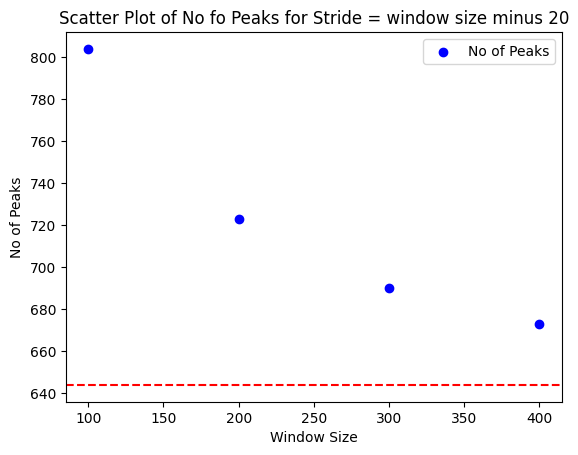

In [185]:
import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = ll

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='No of Peaks')

# # Highlight the point with x=1 in red
# highlight_x = 100
# highlight_y = y[x.index(highlight_x)]
# plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Window Size')
plt.ylabel('No of Peaks')
plt.legend()

# Add a title
plt.title('Scatter Plot of No fo Peaks for Stride = window size minus 20')

# Add a vertical line at y = your_value_here
your_value_here = 644  # Adjust this value as needed
plt.axhline(y=your_value_here, color='red', linestyle='--', label=f'Y = Actual No. of peaks')


# # Set custom x-axis tick values with increased intervals
# custom_x_ticks = [50, 100, 200,400,450,500,1000]  # Adjust these values as needed
# plt.xticks(custom_x_ticks)

# Show the plot
plt.show()


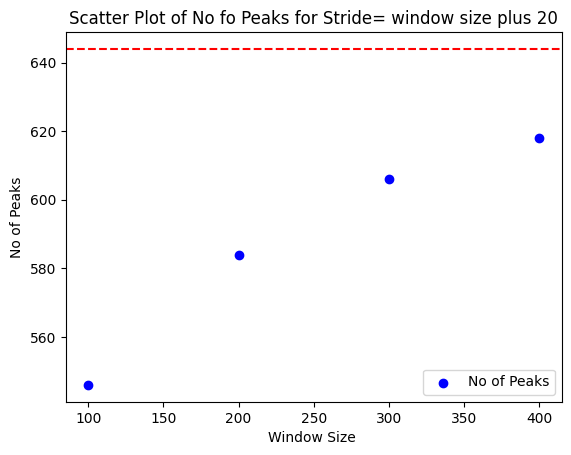

In [186]:
ll = []
for x in range(100,500,100):
    voltage_scaled = scaling(voltage)
    segmented_windows,segment_labels = generate_windows(x,x+20)
    window_data = generate_df(segmented_windows,segment_labels)
    svm_classifier = model_training(segmented_windows,segment_labels)
    label_counts = window_data['Label'].value_counts()
    label2_count = label_counts[1]
    ll.append(label2_count)
    
    import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = ll

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='No of Peaks')

# # Highlight the point with x=1 in red
# highlight_x = 100
# highlight_y = y[x.index(highlight_x)]
# plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Window Size ')
plt.ylabel('No of Peaks')
plt.legend()

# Add a title
plt.title('Scatter Plot of No fo Peaks for Stride= window size plus 20')
# Add a vertical line at y = your_value_here
your_value_here = 644  # Adjust this value as needed
plt.axhline(y=your_value_here, color='red', linestyle='--', label=f'Y = Actual No. of peaks')


# # Set custom x-axis tick values with increased intervals
# custom_x_ticks = [50, 100, 200,400,450,500,1000]  # Adjust these values as needed
# plt.xticks(custom_x_ticks)

# Show the plot
plt.show()


In [90]:
voltage_scaled_t = scaling(t_voltage)
segmented_windows_t,segment_labels_t = test_windowing(voltage_scaled_t,t_labels,t_time_t,100,100)
window_data_t,X_test,y_test = test_df(segmented_windows_t,segment_labels_t)

In [91]:
window_data_t['Label'].value_counts()

Label
0.0    859
1.0    141
Name: count, dtype: int64

In [92]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       859
         1.0       0.84      0.82      0.83       141

    accuracy                           0.95      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.95      0.95      0.95      1000

ROC-AUC score 0.8985419298375977
Matthews Correlation Coefficient: 0.8042979786210396


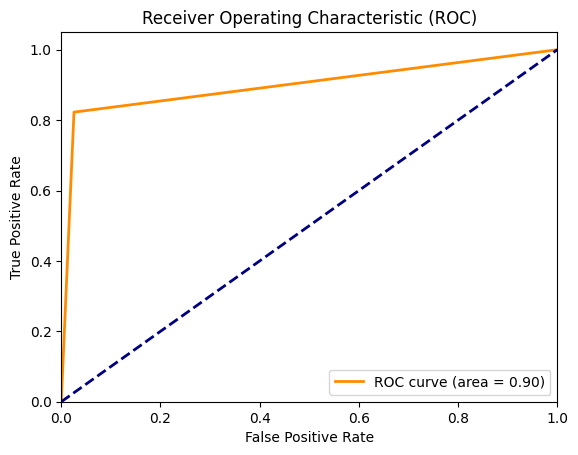

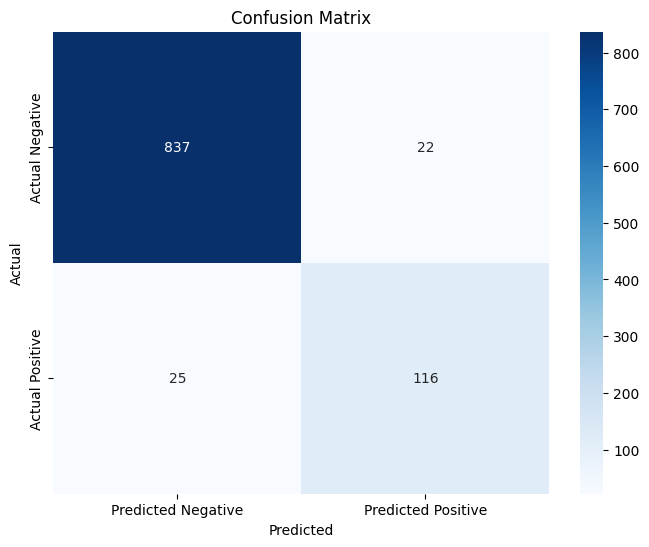

In [93]:

from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score,matthews_corrcoef, roc_curve, auc
roc_auc = roc_auc_score(y_test, y_pred)
mcc_score = matthews_corrcoef(y_test, y_pred)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 50,50

In [94]:
voltage_scaled = scaling(voltage)
segmented_windows,segment_labels = generate_windows(50,50)
window_data = generate_df(segmented_windows,segment_labels)
svm_classifier = model_training(segmented_windows,segment_labels)
window_data['Label'].value_counts()

Label
0.0    9356
1.0     644
Name: count, dtype: int64

In [95]:
voltage_scaled_t = scaling(t_voltage)
segmented_windows_t,segment_labels_t = test_windowing(voltage_scaled_t,t_labels,t_time_t,50,50)
window_data_t,X_test,y_test = test_df(segmented_windows_t,segment_labels_t)
window_data_t['Label'].value_counts()

Label
0.0    1859
1.0     141
Name: count, dtype: int64

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1859
         1.0       0.82      0.71      0.76       141

    accuracy                           0.97      2000
   macro avg       0.90      0.85      0.87      2000
weighted avg       0.97      0.97      0.97      2000

ROC-AUC score 0.8486927693147007
Matthews Correlation Coefficient: 0.7459238257271997


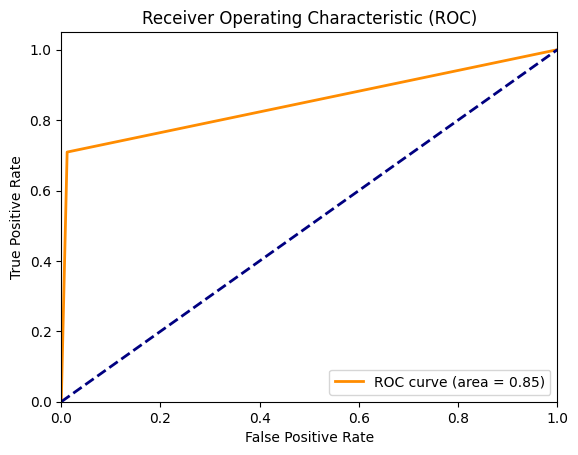

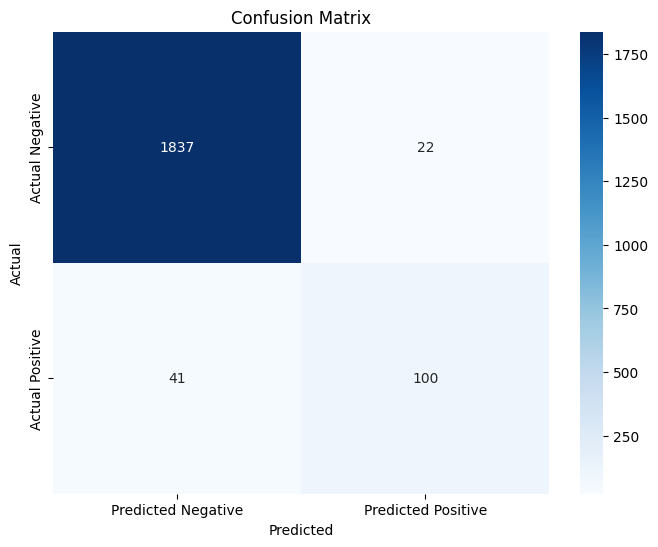

In [96]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score,matthews_corrcoef, roc_curve, auc
roc_auc = roc_auc_score(y_test, y_pred)
mcc_score = matthews_corrcoef(y_test, y_pred)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
from sklearn.metrics import confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
f1_sco = []
rocccc = []
mccccc = []

In [98]:
for i in range(100,1001,50):
    print("\t************************\t")
    print(i)
    voltage_scaled = scaling(voltage)
    segmented_windows,segment_labels = generate_windows(i,i)
    window_data = generate_df(segmented_windows,segment_labels)
    svm_classifier = model_training(segmented_windows,segment_labels)
#     print(window_data['Label'].value_counts())
    
    voltage_scaled_t = scaling(t_voltage)
    segmented_windows_t,segment_labels_t = test_windowing(voltage_scaled_t,t_labels,t_time_t,50,50)
    window_data_t,X_test,y_test = test_df(segmented_windows_t,segment_labels_t)
#     print(window_data_t['Label'].value_counts())
    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)
#     from sklearn.metrics import classification_report
#     # Print classification report
#     print(classification_report(y_test, y_pred))
    from sklearn.metrics import roc_auc_score,matthews_corrcoef, roc_curve, auc
    roc_auc = roc_auc_score(y_test, y_pred)
    mcc_score = matthews_corrcoef(y_test, y_pred)
#     print("ROC-AUC score", roc_auc)
#     print("Matthews Correlation Coefficient:", mcc_score)
    import matplotlib.pyplot as plt
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_curve = auc(fpr, tpr)

#     plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC)')
#     plt.legend(loc='lower right')
#     plt.show()
#     from sklearn.metrics import confusion_matrix,roc_curve,auc
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     # Calculate confusion matrix
#     cm = confusion_matrix(y_test, y_pred)

#     # Create a heatmap visualization
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#                 xticklabels=["Predicted Negative", "Predicted Positive"],
#                 yticklabels=["Actual Negative", "Actual Positive"])
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix")
#     plt.show()
    f1 = f1_score(y_test, y_pred)
    f1_sco.append(f1)
    rocccc.append(roc_auc)
    mccccc.append(mcc_score)
    


	************************	
100
	************************	
150
	************************	
200
	************************	
250
	************************	
300
	************************	
350
	************************	
400
	************************	
450
	************************	
500
	************************	
550
	************************	
600
	************************	
650
	************************	
700
	************************	
750
	************************	
800
	************************	
850
	************************	
900
	************************	
950
	************************	
1000


In [105]:
samp = []
for i in range(100,1001,50):
    samp.append(i)
    

In [106]:
# samp

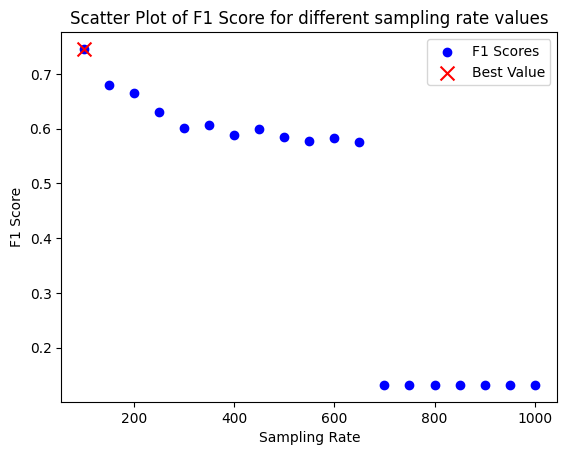

In [108]:
import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = f1_sco

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='F1 Scores')

# Highlight the point with x=1 in red
highlight_x = 100
highlight_y = y[x.index(highlight_x)]
plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Sampling Rate')
plt.ylabel('F1 Score')
plt.legend()

# Add a title
plt.title('Scatter Plot of F1 Score for different sampling rate values')
# Show the plot
plt.show()

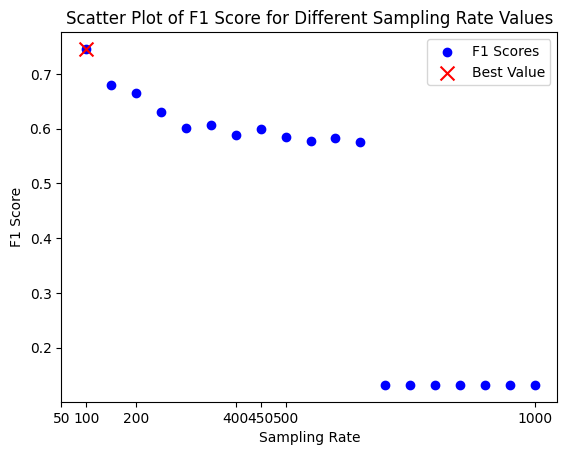

In [109]:
import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = f1_sco

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='F1 Scores')

# Highlight the point with x=1 in red
highlight_x = 100
highlight_y = y[x.index(highlight_x)]
plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Sampling Rate')
plt.ylabel('F1 Score')
plt.legend()

# Add a title
plt.title('Scatter Plot of F1 Score for Different Sampling Rate Values')

# Set custom x-axis tick values with increased intervals
custom_x_ticks = [50, 100, 200,400,450,500,1000]  # Adjust these values as needed
plt.xticks(custom_x_ticks)

# Show the plot
plt.show()


ValueError: 50 is not in list

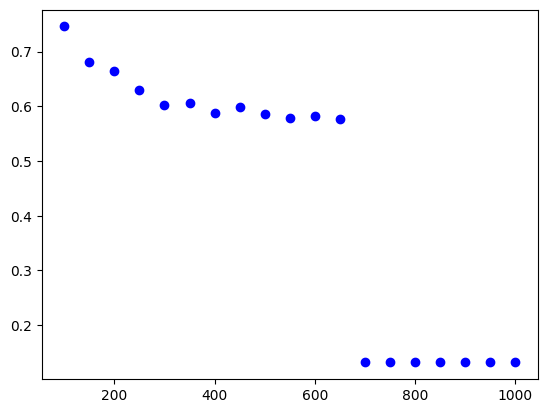

In [110]:
import matplotlib.pyplot as plt

# Sample data for X and Y
x = samp
y = f1_sco

# Create a scatter plot with dots
plt.scatter(x, y, marker='o', color='blue', label='F1 Scores')

# Highlight the point with x=1 in red
highlight_x = 50
highlight_y = y[x.index(highlight_x)]
plt.scatter(highlight_x, highlight_y, marker='x', color='red', s=100, label='Best Value')

# Add labels and a legend
plt.xlabel('Sampling Rate')
plt.ylabel('F1 Score')
plt.legend()

# Add a title
plt.title('Scatter Plot of F1 Score for Different Sampling Rate Values')

# Set custom x-axis tick values with increased intervals
custom_x_ticks = [50, 100, 200,400,450,500,1000]  # Adjust these values as needed
plt.xticks(custom_x_ticks)

# Show the plot
plt.show()


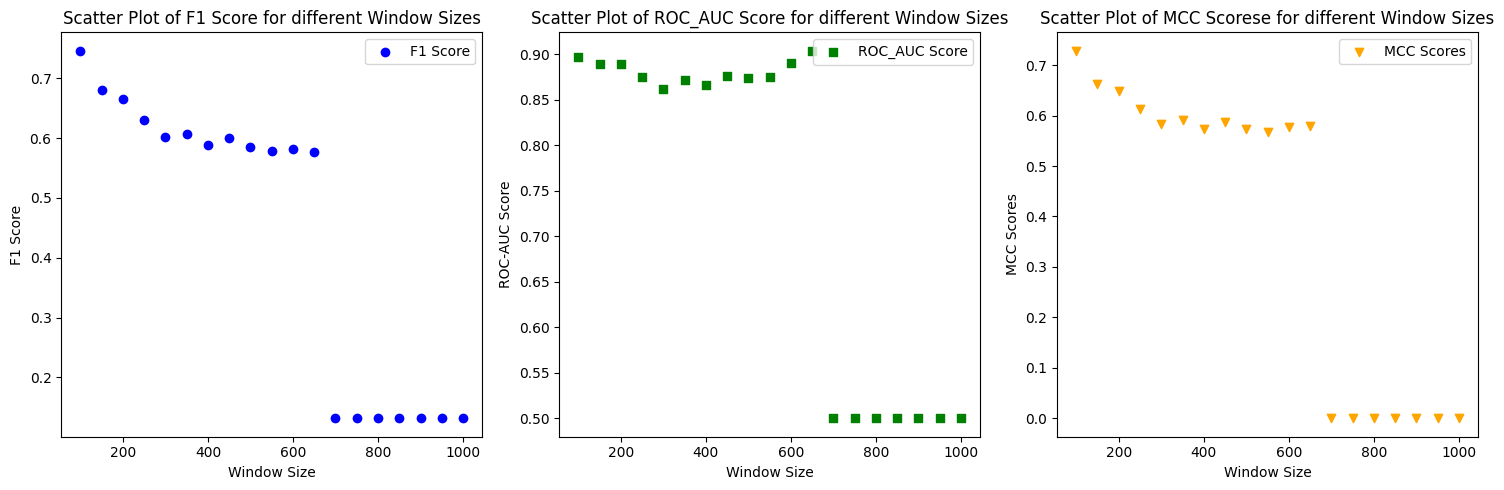

In [113]:
import matplotlib.pyplot as plt

# Sample data for X, Y, Z, and W
x = f1_sco
y = samp
z = rocccc
w = mccccc

# Create a figure with three subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Scatter plot for X and Y
ax1.scatter(y, x, marker='o', color='blue', label='F1 Score')
ax1.set_xlabel('Window Size')
ax1.set_ylabel('F1 Score')
ax1.legend()
ax1.set_title('Scatter Plot of F1 Score for different Window Sizes')

# Subplot 2: Scatter plot for Z and Y
ax2.scatter(y, z, marker='s', color='green', label='ROC_AUC Score')
ax2.set_xlabel('Window Size')
ax2.set_ylabel('ROC-AUC Score')
ax2.legend()
ax2.set_title('Scatter Plot of ROC_AUC Score for different Window Sizes')

# Subplot 3: Scatter plot for W and Y
ax3.scatter(y, w, marker='v', color='orange', label='MCC Scores')
ax3.set_xlabel('Window Size')
ax3.set_ylabel('MCC Scores')
ax3.legend()
ax3.set_title('Scatter Plot of MCC Scorese for different Window Sizes')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()
